# Copyright
<pre>
Jelen forráskód a Budapesti Műszaki és Gazdaságtudományi Egyetemen 
tartott "Deep Learning a gyakorlatban Python és LUA alapon" tantárgy segédanyagaként készült.

A tantárgy honlapja: http://smartlab.tmit.bme.hu/oktatas-deep-learning
Deep Learning kutatás: http://smartlab.tmit.bme.hu/deep-learning

A forráskódot GPLv3 licensz védi. Újrafelhasználás esetén lehetőség szerint kérejük az alábbi szerzőt értesíteni.

2019 (c) Gyires-Tóth Bálint (toth.b kukac tmit pont bme pont hu), Zainkó Csaba
</pre>

Jelen notebook egy példakódot mutat be egy dimenziós konvolúció alapú szekvenciális adat modellezésre. A példakód elsődlegesen az 1D konvolúcióra koncentrál, az általános megfontolások (standardizálás, min-max skálázás, early stopping, regularizáció, stb.) itt nem szerepelnek, de éles feladatokban szükségszerűek. 

In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers.core import Activation, Dense, Flatten
from keras.optimizers import SGD
import matplotlib.pyplot as plt
from keras.layers.convolutional import  Conv1D, MaxPooling1D

Using TensorFlow backend.


Az egy dimenziós konvolúciós rétegek létrehozása.

In [2]:
def make_1d_convnet(window_size, filter_length, nb_input_series=1, nb_outputs=1, nb_filter=4):
    model = Sequential()
    model.add(Conv1D(filters=nb_filter, kernel_size=filter_length, activation='relu', input_shape=(window_size, nb_input_series)))
    model.add(MaxPooling1D())
    model.add(Conv1D(filters=nb_filter, kernel_size=filter_length, activation='relu'))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(nb_outputs, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    return model

Az idősor adatokból az egy dimenziós konvolúció számára megfelelő formátum létrehozása.

In [3]:
def make_timeseries_instances(timeseries, window_size):
    timeseries = np.asarray(timeseries)
    assert 0 < window_size < timeseries.shape[0] , "Out of range 0 < {} < {} ".format(window_size,timeseries.shape[0])
    X = np.atleast_3d(np.array([timeseries[start:start + window_size] for start in range(0, timeseries.shape[0] - window_size)]))
    Y = timeseries[window_size:]
    return X, Y

A hálózat létrehozását, adatok formázását és tanítását az alábbi függvény végzi, és visszatér a predikcióval és az eredeti értékekkel:

In [4]:
def evaluate_timeseries(timeseries, window_size, valid_split=0.15, test_split=0.15):
    filter_length = 5
    nb_filter = 4
    timeseries = np.atleast_2d(timeseries)
    if timeseries.shape[0] == 1:
        timeseries = timeseries.T       # 1D vektor -> 2D matrix
    nb_samples, nb_series = timeseries.shape
    model = make_1d_convnet(window_size=window_size, filter_length=filter_length, nb_input_series=nb_series, nb_outputs=nb_series, nb_filter=nb_filter)
    model.summary()
    X, Y = make_timeseries_instances(timeseries, window_size)
    
    valid_size = int(nb_samples*(1-test_split-valid_split))
    test_size = int(nb_samples*(1-test_split))
    X_train, Y_train = X[:valid_size], Y[:valid_size]
    X_valid, Y_valid = X[valid_size:test_size], Y[valid_size:test_size]
    X_test, Y_test   = X[test_size:], Y[test_size:]
    
    model.fit(X_train, Y_train, epochs=50, batch_size=16, validation_data=(X_valid, Y_valid), verbose=2)
    
    preds   = model.predict(X_test)

    return Y_test, preds   


Minta adatok létrehozása és a tanítás meghívása. 

In [5]:
# adatok elkészítése
lp 	= np.linspace(-10*np.pi,10*np.pi,1000)
X 	= np.sin(lp)*3+np.cos(lp*2)+np.sin(np.pi/2+lp*4)*1.5+np.log(np.abs(lp))
window_size = 20

targets, preds = evaluate_timeseries(X, window_size)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 16, 4)             24        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 4)              0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4, 4)              84        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 2, 4)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 117
Trainable params: 117
Non-trainable params: 0
_________________________________________________________________
Train on 700

Végül megjelenítjük a predikciót és az eredeti értékeket. 

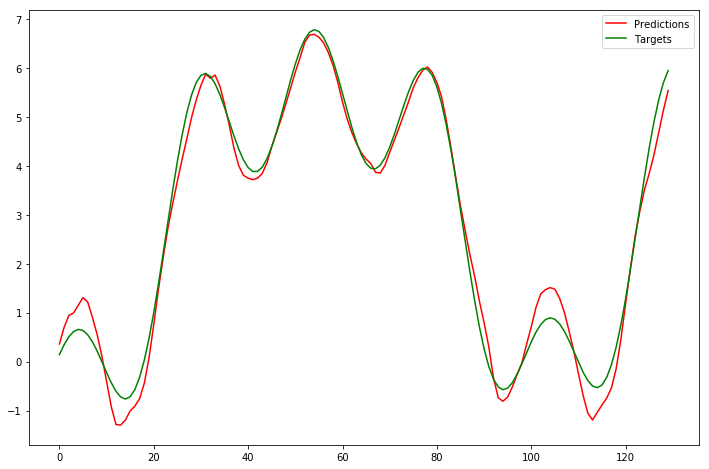

In [6]:
plt.figure(figsize=(12,8))
plt.plot(preds, color='r', label="Predictions")
plt.plot(targets, color='g', label="Targets")
plt.legend()